**Download Stuff**

## Code

In [2]:
# Import libraries
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2

# cv2.imshow() is broken for colab, can use this patched function instead

In [4]:
def show_image(img, scale=1.0):
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    cv2_imshow(resized)

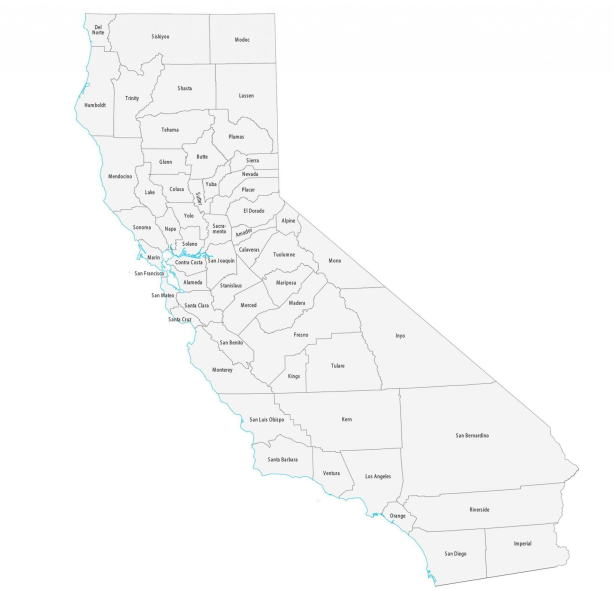

In [5]:
# Load image into numpy array
img_path = "states/california.jpg"
img = cv2.imread(img_path)
show_image(img, 0.3)

### Detect possible text regions

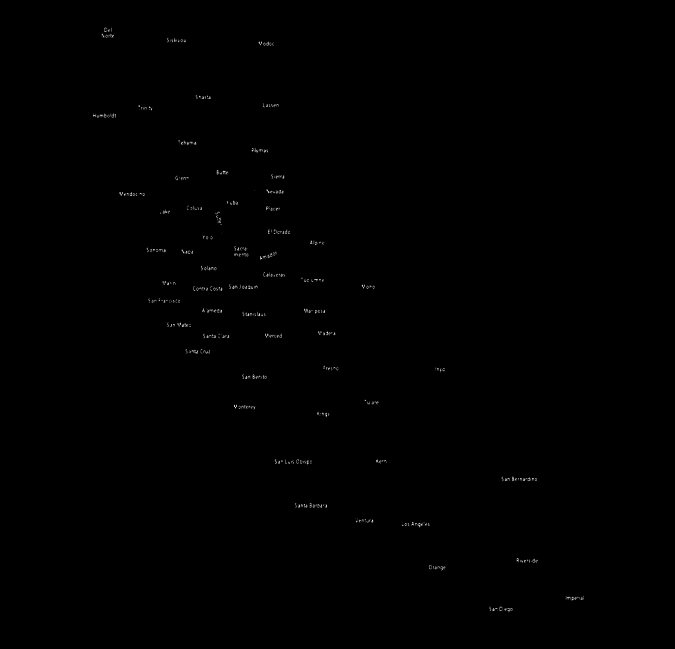

In [6]:
# rough cleanup - removing lines
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.blur(gray,(3,3))
ret,thresh = cv2.threshold(blur, 130, 255, cv2.THRESH_BINARY_INV)
show_image(thresh, 0.33)

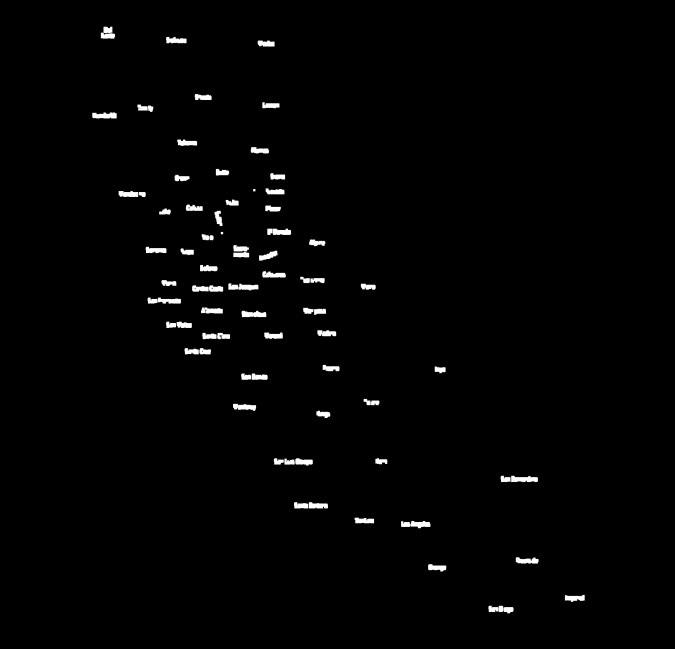

In [7]:
# Get rough estimate of text regions
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(thresh, kernel, iterations = 3)
show_image(dilation, 0.33)

((831, 1389), (860, 1407)) , ((863, 1390), (893, 1407))
((831, 1389), (893, 1407)) , ((896, 1389), (948, 1410))
((1217, 1580), (1244, 1596)) , ((1246, 1579), (1305, 1600))


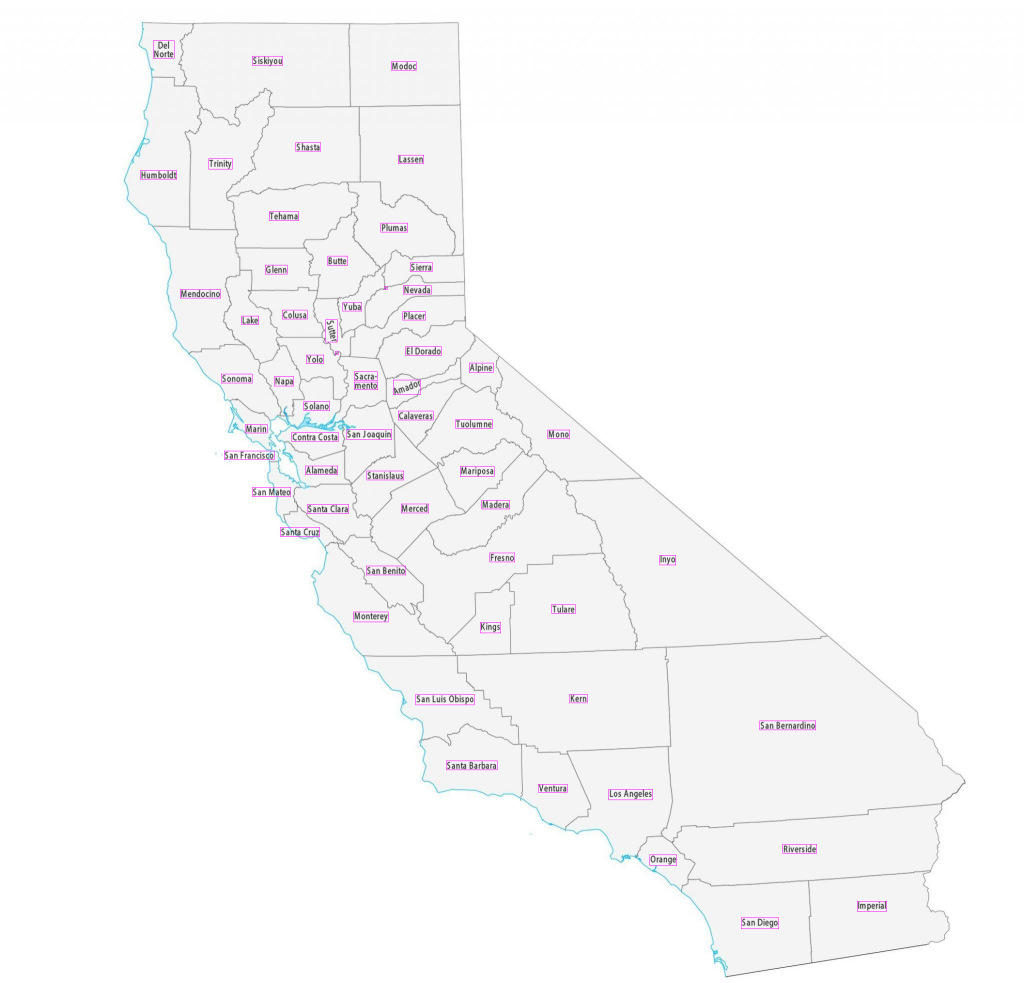

In [8]:
def get_contour_extreme_points(c):
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    # print(extLeft, extRight, extTop, extBot)
    return (extLeft[0], extTop[1]), (extRight[0], extBot[1])
    

def get_text_bounding_boxes(src_img):
    contours, hierarchy = cv2.findContours(src_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bounds = []
    min_area = 10
    gap = 20
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            cur_point = get_contour_extreme_points(contour)
            if len(bounds) != 0:
              last = bounds[-1]
              left_right_diff = abs(last[0][0] - cur_point[1][0])
              right_left_diff = abs(last[0][0] - cur_point[0][0])
              if left_right_diff <= gap or right_left_diff <= gap:
                new_point_left = min(last[0][0], cur_point[0][0])
                new_point_top = min(last[0][1], cur_point[0][1])
                new_point_right = max(last[1][0], cur_point[1][0])
                new_point_bot = max(last[1][1], cur_point[1][1])
                new_point = (new_point_left, new_point_top), (new_point_right, new_point_bot)
                del bounds[-1]
                bounds.append(new_point)
                continue
            bounds.append(cur_point)
    return bounds
def optimize(bounds):
  n = len(bounds)
  top_bot_gap = 20
  right_left_gap = 10
  bounds = sorted(bounds, key = lambda x: x[0][0])
  for i in range(0, n):
    cur_i = bounds[i]
    if cur_i is None:
      continue
    for j in range(i+1, n):
      cur_j = bounds[j]
      if cur_j is None:
        continue;
      right_left_diff = abs(cur_i[1][0] - cur_j[0][0])
      top_bot_diff = abs(cur_i[1][1] - cur_j[0][1])
      bot_bot_diff = abs(cur_i[1][1] - cur_j[1][1])
      if right_left_diff <= right_left_gap and bot_bot_diff < top_bot_gap:
        print(cur_i, ",", cur_j)
      if right_left_diff <= right_left_gap and bot_bot_diff <= top_bot_gap:
        new_point_left = min(cur_i[0][0], cur_j[0][0])
        new_point_top = min(cur_i[0][1], cur_j[0][1])
        new_point_right = max(cur_i[1][0], cur_j[1][0])
        new_point_bot = max(cur_i[1][1], cur_j[1][1])
        new_point = (new_point_left, new_point_top), (new_point_right, new_point_bot)
        bounds[i] = new_point
        cur_i = bounds[i]
        bounds[j] = None
  new_list = []
  for val in bounds:
    if val is not None:
      new_list.append(val)
  return new_list

def draw_bounds(src_img, bounds, buffer=0):
    img_copy = np.copy(src_img)
    color = (255,0,255)
    thickness = 1

    for start_point, end_point in bounds:
        img_copy = cv2.rectangle(img_copy, 
                                 (start_point[0]-buffer, start_point[1]-buffer), 
                                 (end_point[0]+buffer, end_point[1]+buffer), 
                                 color, thickness)
    
    return img_copy

# manually find text regions(text detection)
bounds = get_text_bounding_boxes(dilation)
bounds = optimize(bounds)
# draw rectangles around text
img_bounds = draw_bounds(img, bounds)
show_image(img_bounds, .5)

### OCR

In [9]:
!pip install pytesseract

     |████████████████████████████████| 4.3 MB 9.7 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [52]:
population_dict = dict()
with open('sample_data/population.txt') as f:
    for line in f:
        line = line.replace("\n", "")
        line = re.split(r'\t+', line)
        state = line[0]
        county = line[1]
        county = county.replace("County","").strip()
        county = county.replace(" ","")
        population = line[2]
        if state not in population_dict: 
            population_dict[state] = {}
        population_dict[state][county] = population

In [53]:
print(population_dict)

{'TX': {'Harris': '4,813,165', 'Dallas': '2,654,014', 'Tarrant': '2,165,722', 'Bexar': '2,070,655', 'Travis': '1,356,100', 'Collin': '1,125,999', 'Denton': '972,605', 'Hidalgo': '887,934', 'FortBend': '882,509', 'ElPaso': '846,477', 'Williamson': '662,815', 'Montgomery': '660,254', 'Cameron': '426,235', 'Brazoria': '390,395', 'Bell': '385,505', 'Nueces': '363,098', 'Galveston': '354,982', 'Lubbock': '319,395', 'Webb': '281,248', 'McLennan': '263,904', 'Hays': '252,646', 'Jefferson': '246,558', 'Smith': '241,757', 'Brazos': '239,501', 'Ellis': '202,286', 'Johnson': '189,905', 'Midland': '189,813', 'Comal': '180,413', 'Ector': '179,012', 'Guadalupe': '177,560', 'Kaufman': '159,779', 'Parker': '157,302', 'Randall': '143,779', 'Grayson': '143,487', 'Taylor': '140,254', 'Wichita': '133,499', 'Gregg': '126,027', 'TomGreen': '122,758', 'Rockwall': '118,022', 'Potter': '113,527', 'Hunt': '104,558', 'Liberty': '95,470', 'Bastrop': '95,107', 'Victoria': '92,702', 'Bowie': '91,916', 'Angelina': '

In [55]:
import pytesseract
from PIL import Image
import re
# pytesseract.pytesseract.tesseract_cmd = (r'/usr/local/bin/pytesseract')

def do_ocr(src_img, bounds, buffer=5, state='CA'):
    texts = []
    for start_point, end_point in bounds:

        # crop each text region into a seperate image before passing it to tesseract
        crop = img_rgb[start_point[1]-buffer:end_point[1]+buffer,
                       start_point[0]-buffer:end_point[0]+buffer,
                       :]

        # convert cropped image region from numpy(opencv) to pillow format
        im_pil = Image.fromarray(crop)

        # do ocr
        text = pytesseract.image_to_string(im_pil)
        text = re.sub(r'[^a-zA-Z]', '', text)
        if text in population_dict[state]:
          texts.append(population_dict[state][text])
        else:
          texts.append("")

    return texts

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
texts = do_ocr(img_rgb, bounds)

In [56]:
print(texts)

['133,500', '28,028', '84,793', '11,439', '481,415', '884,108', '64,593', '256,318', '760,249', '', '29,671', '68,282', '134,609', '271,329', '21,934', '1,162,547', '181,193', '453,397', '1,685,048', '221,646', '1,914,397', '', '185,727', '', '82,001', '', '434,394', '', '', '66,831', '558,262', '19,005', '', '8,964', '', '46,526', '30,438', '288,267', '416,326', '100,496', '199,134', '3,029', '282,382', '448,656', '54,751', '16,597', '1,249', '157,614', '158,662', '1,020,554', '839,598', '14,567', '471,013', '919,534', '9,934,710', '3,174,849', '18,318', '3,351,737', '2,220,081', '2,544,817', '180,291']


### Show Results

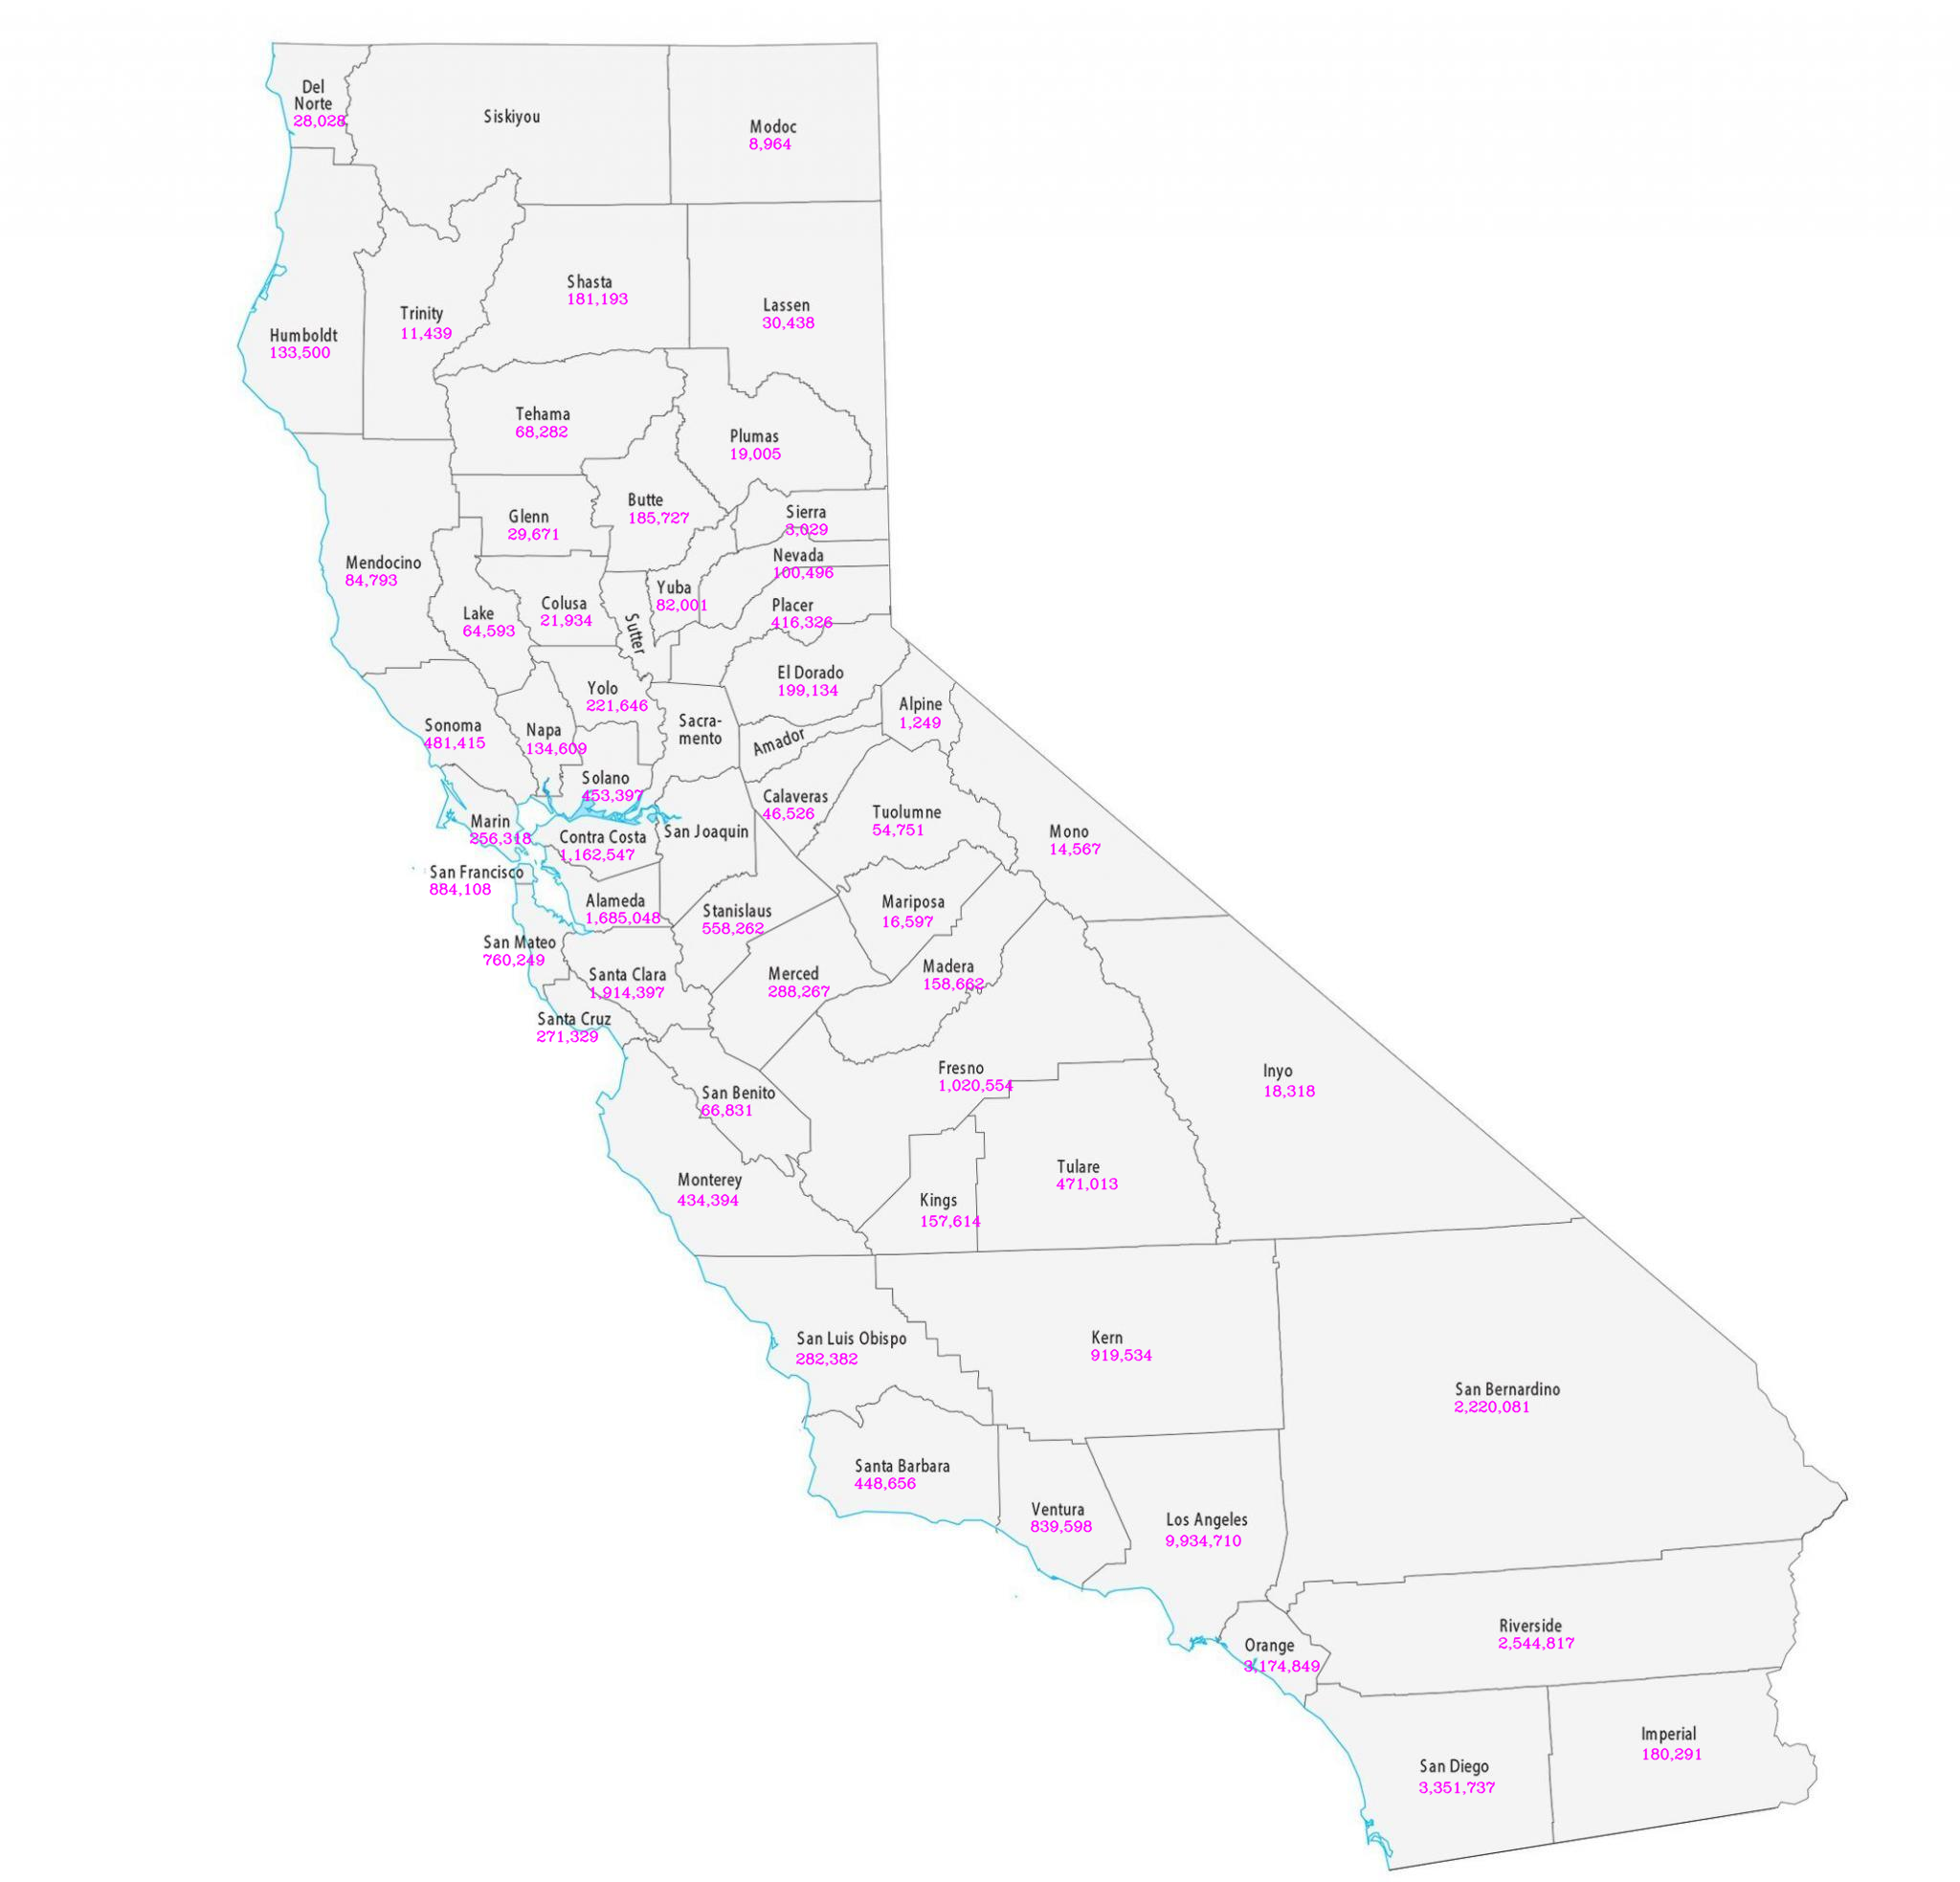

In [57]:
def draw_texts(src_img, texts, bounds, offset):
    img_copy = np.copy(src_img)
    color = (255,0,255)
    thickness = 1
    font = cv2.FONT_HERSHEY_COMPLEX
    fontScale = 0.5
    thickness = 1

    for i, text in enumerate(texts):
        if len(text) > 0:
            start_point, end_point = bounds[i]
            position = (start_point[0], end_point[1]+offset)

            image = cv2.putText(img_copy, text, position, font, 
                            fontScale, color, thickness, cv2.LINE_AA)
    
    return img_copy

text_image = draw_texts(img, texts, bounds, 15)
show_image(text_image)